## RNN HW

Brown (nltk.corpus) data 

Fitting & Evaluation on
- Vanilla RNN model
- LSTM
- bidirectional LSTM

In [19]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

import nltk

import seaborn as sns

from gensim.models import KeyedVectors #pip install : for word2vec

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [6]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [20]:
from nltk.corpus import brown
brown.words()

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [21]:
brown_corpus = brown.tagged_sents(tagset="universal")
tagged_sentences = brown_corpus
tagged_sentences[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

In [22]:
#Divide data into sentences(X) and tags(Y)
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [23]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags = len(set([word.lower() for sentence in Y for word in sentence]))

In [24]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 57340
Vocabulary size: 49815
Total number of tags: 12


In [25]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], )

sample X:  ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'] 

sample Y:  ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']


In [26]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 25
Length of first output sequence : 25


### X and Y encoding

In [27]:
word_tokenizer = Tokenizer()                     
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

print("## Raw data point ##", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("## Encoded data point ##", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

## Raw data point ## 
 ---------------------------------------------------------------------------------------------------- 

X:  ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'] 

Y:  ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.'] 


## Encoded data point ## 
 ---------------------------------------------------------------------------------------------------- 

X:  [1, 5433, 651, 2296, 1634, 62, 1846, 35, 2177, 4, 14222, 551, 1120, 1401, 1193, 14, 59, 473, 15, 9, 85, 9199, 213, 171, 3] 

Y:  [5, 1, 1, 6, 1, 2, 1, 5, 1, 4, 1, 6, 1, 1, 2, 3, 5, 1, 3, 4, 5, 1, 2, 1, 3] 



### Pad encoded sequences

In [28]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))
print("Length of shortest sentence: {}".format(min(lengths)))

Length of longest sentence: 180
Length of shortest sentence: 1


In [29]:
# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.


MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [30]:
print(X_encoded[0],"\n")
print(X_padded[0], "\n")
print(Y_encoded[0],"\n")
print(Y_padded[0])

[1, 5433, 651, 2296, 1634, 62, 1846, 35, 2177, 4, 14222, 551, 1120, 1401, 1193, 14, 59, 473, 15, 9, 85, 9199, 213, 171, 3] 

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     1  5433   651  2296  1634    62  1846    35  2177
     4 14222   551  1120  1401  1193    14    59   473    15     9    85
  9199   213   171     3] 

[5, 1, 1, 6, 1, 2, 1, 5, 1, 4, 1, 6, 1, 1, 2, 3, 5, 1, 3, 4, 5, 1, 2, 1, 3] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 5 1 1 6 1 2 1 5 1 4 1 6 1 1 2 3 

In [31]:
X, Y = X_padded, Y_padded

In [32]:
print(X.shape)
print(Y.shape)

(57340, 100)
(57340, 100)


## Word Embeddings

In [15]:
#Use word2vec as pretrained data from GoogleNews
path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True) #binary=TRUE for word2vec embedding

In [16]:
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"],topn=1)

KeyboardInterrupt: 

In [ ]:
word2vec.most_similar(positive = ["Queen", "Man"], negative = ["Woman"],topn=1)


In [33]:
EMBEDDING_SIZE  = 300  #embedding (hidden) size = 300으로 설정 : hyperparameter이지만 word2vec의 dimension에 맞추어 조정
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1 #첫번째 index가 0로 할당되므로 +1해주어야함

In [35]:
# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [36]:
word2id

{'the': 1,
 ',': 2,
 '.': 3,
 'of': 4,
 'and': 5,
 'to': 6,
 'a': 7,
 'in': 8,
 'that': 9,
 'is': 10,
 'was': 11,
 'he': 12,
 'for': 13,
 '``': 14,
 "''": 15,
 'it': 16,
 'with': 17,
 'as': 18,
 'his': 19,
 'on': 20,
 'be': 21,
 ';': 22,
 'at': 23,
 'by': 24,
 'i': 25,
 'this': 26,
 'had': 27,
 '?': 28,
 'not': 29,
 'are': 30,
 'but': 31,
 'from': 32,
 'or': 33,
 'have': 34,
 'an': 35,
 'they': 36,
 'which': 37,
 '--': 38,
 'one': 39,
 'you': 40,
 'were': 41,
 'her': 42,
 'all': 43,
 'she': 44,
 'there': 45,
 'would': 46,
 'their': 47,
 'we': 48,
 'him': 49,
 'been': 50,
 ')': 51,
 'has': 52,
 '(': 53,
 'when': 54,
 'who': 55,
 'will': 56,
 'more': 57,
 'if': 58,
 'no': 59,
 'out': 60,
 'so': 61,
 'said': 62,
 'what': 63,
 'up': 64,
 'its': 65,
 'about': 66,
 ':': 67,
 'into': 68,
 'than': 69,
 'them': 70,
 'can': 71,
 'only': 72,
 'other': 73,
 'new': 74,
 'some': 75,
 'could': 76,
 'time': 77,
 '!': 78,
 'these': 79,
 'two': 80,
 'may': 81,
 'then': 82,
 'do': 83,
 'first': 84,
 'any

In [37]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (49816, 300)


In [38]:
embedding_weights[word_tokenizer.word_index['time']] #11388 by 300 dimension matrix

array([-4.73632812e-02,  1.87500000e-01,  2.25830078e-03,  1.73828125e-01,
       -1.59912109e-02, -1.50390625e-01,  1.13769531e-01, -1.55029297e-02,
        2.19726562e-01, -1.01318359e-02,  1.50146484e-02, -1.03515625e-01,
        5.34057617e-03, -6.59179688e-02, -1.92382812e-01,  3.89099121e-03,
        1.42211914e-02,  8.30078125e-02,  1.30859375e-01, -1.95312500e-01,
       -1.19628906e-01, -9.57031250e-02, -4.90722656e-02,  6.10351562e-03,
       -1.31225586e-02,  1.25976562e-01,  5.37109375e-02,  4.56542969e-02,
        3.32031250e-02,  1.56250000e-01,  1.33666992e-02,  4.39453125e-02,
       -4.68750000e-02,  1.39648438e-01,  1.58203125e-01, -4.88281250e-02,
        1.11694336e-02, -1.96289062e-01, -7.17773438e-02,  1.82617188e-01,
        1.36718750e-01, -7.37304688e-02,  1.73828125e-01, -8.69140625e-02,
       -1.83105469e-02,  5.61523438e-02, -1.62353516e-02,  1.57226562e-01,
       -4.76074219e-02,  8.25195312e-02,  4.58984375e-02, -1.33789062e-01,
       -3.32031250e-02, -

In [39]:
# to_categorical을 이용하여 Y를 one-hot encoding시킴
Y = to_categorical(Y)

In [40]:
print(Y.shape)
print(X.shape)

(57340, 100, 13)
(57340, 100)


## Split data into test/train sets

In [41]:
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [42]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [43]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (41428, 100)
Shape of output sequences: (41428, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (7311, 100)
Shape of output sequences: (7311, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (8601, 100)
Shape of output sequences: (8601, 100, 13)


# Vanilla RNN

In [45]:
# total number of tags
NUM_CLASSES = Y.shape[2]
NUM_CLASSES

13

In [46]:
EMBEDDING_SIZE  = 300  #embedding (hidden) size = 300으로 설정 : hyperparameter이지만 word2vec의 dimension에 맞추어 조정
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1 #첫번째 index가 0로 할당되므로 +1해주어야함

### 1. Without pretrained weight, or update

In [78]:
rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence(100)
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 hidden RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [79]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [80]:
rnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          14944800  
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 13)           845       
Total params: 14,969,005
Trainable params: 24,205
Non-trainable params: 14,944,800
_________________________________________________________________


In [81]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))


Epoch 1/10
324/324 [==============================] - 25s 75ms/step - loss: 0.7605 - acc: 0.8046 - val_loss: 0.3364 - val_acc: 0.8992
Epoch 2/10
324/324 [==============================] - 26s 81ms/step - loss: 0.3057 - acc: 0.9069 - val_loss: 0.2352 - val_acc: 0.9275
Epoch 3/10
324/324 [==============================] - 24s 74ms/step - loss: 0.2209 - acc: 0.9312 - val_loss: 0.1876 - val_acc: 0.9409
Epoch 4/10
324/324 [==============================] - 24s 74ms/step - loss: 0.1815 - acc: 0.9424 - val_loss: 0.1612 - val_acc: 0.9480
Epoch 5/10
324/324 [==============================] - 23s 70ms/step - loss: 0.1584 - acc: 0.9486 - val_loss: 0.1454 - val_acc: 0.9522
Epoch 6/10
324/324 [==============================] - 24s 75ms/step - loss: 0.1436 - acc: 0.9526 - val_loss: 0.1357 - val_acc: 0.9544
Epoch 7/10
324/324 [==============================] - 22s 68ms/step - loss: 0.1334 - acc: 0.9554 - val_loss: 0.1281 - val_acc: 0.9573
Epoch 8/10
324/324 [==============================] - 25s 79ms

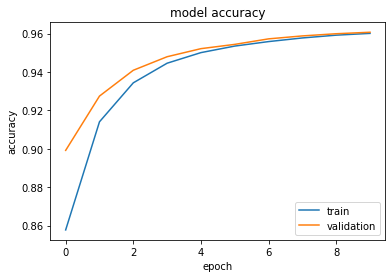

In [82]:
#visualize
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()

### 2. Updated, and pretrained weight

In [67]:
# create architecture

rnn_pretrained_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_pretrained_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_pretrained_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_pretrained_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [68]:
rnn_pretrained_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [69]:
rnn_pretrained_model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          14944800  
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 13)           845       
Total params: 14,969,005
Trainable params: 14,969,005
Non-trainable params: 0
_________________________________________________________________


In [51]:
rnn_training = rnn_pretrained_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))


Epoch 1/10
324/324 [==============================] - 88s 267ms/step - loss: 0.5231 - acc: 0.9057 - val_loss: 0.0349 - val_acc: 0.9897
Epoch 2/10
324/324 [==============================] - 84s 258ms/step - loss: 0.0276 - acc: 0.9916 - val_loss: 0.0247 - val_acc: 0.9916
Epoch 3/10
324/324 [==============================] - 84s 259ms/step - loss: 0.0181 - acc: 0.9939 - val_loss: 0.0223 - val_acc: 0.9921
Epoch 4/10
324/324 [==============================] - 87s 270ms/step - loss: 0.0145 - acc: 0.9950 - val_loss: 0.0214 - val_acc: 0.9925
Epoch 5/10
324/324 [==============================] - 88s 272ms/step - loss: 0.0124 - acc: 0.9957 - val_loss: 0.0211 - val_acc: 0.9926
Epoch 6/10
324/324 [==============================] - 77s 237ms/step - loss: 0.0107 - acc: 0.9962 - val_loss: 0.0211 - val_acc: 0.9926
Epoch 7/10
324/324 [==============================] - 78s 240ms/step - loss: 0.0098 - acc: 0.9966 - val_loss: 0.0213 - val_acc: 0.9927
Epoch 8/10
324/324 [==============================] - 8

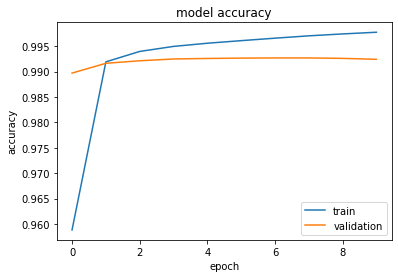

In [52]:
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()


## LSTM (pretrained & updating)

In [53]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [54]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [55]:
lstm_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          14944800  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 64)           93440     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 13)           845       
Total params: 15,039,085
Trainable params: 15,039,085
Non-trainable params: 0
_________________________________________________________________


In [56]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))


Epoch 1/10
324/324 [==============================] - 105s 319ms/step - loss: 0.7467 - acc: 0.8750 - val_loss: 0.0563 - val_acc: 0.9866
Epoch 2/10
324/324 [==============================] - 120s 370ms/step - loss: 0.0430 - acc: 0.9891 - val_loss: 0.0295 - val_acc: 0.9906
Epoch 3/10
324/324 [==============================] - 109s 337ms/step - loss: 0.0239 - acc: 0.9924 - val_loss: 0.0248 - val_acc: 0.9916
Epoch 4/10
324/324 [==============================] - 104s 321ms/step - loss: 0.0186 - acc: 0.9937 - val_loss: 0.0228 - val_acc: 0.9919
Epoch 5/10
324/324 [==============================] - 109s 335ms/step - loss: 0.0160 - acc: 0.9943 - val_loss: 0.0218 - val_acc: 0.9923
Epoch 6/10
324/324 [==============================] - 108s 334ms/step - loss: 0.0140 - acc: 0.9950 - val_loss: 0.0212 - val_acc: 0.9925
Epoch 7/10
324/324 [==============================] - 106s 328ms/step - loss: 0.0128 - acc: 0.9953 - val_loss: 0.0211 - val_acc: 0.9925
Epoch 8/10
324/324 [============================

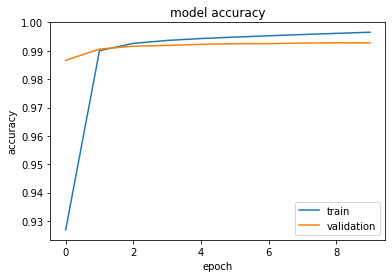

In [59]:
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()


## Bidirectional LSTM

In [60]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [61]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [62]:
bidirect_model.summary() #parameter for bidirectional = 2 times original LSTM

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          14944800  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 13)           1677      
Total params: 15,133,357
Trainable params: 15,133,357
Non-trainable params: 0
_________________________________________________________________


In [63]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_validation, Y_validation))

Epoch 1/15
324/324 [==============================] - 157s 476ms/step - loss: 0.6494 - acc: 0.8698 - val_loss: 0.0332 - val_acc: 0.9909
Epoch 2/15
324/324 [==============================] - 148s 456ms/step - loss: 0.0260 - acc: 0.9928 - val_loss: 0.0191 - val_acc: 0.9941
Epoch 3/15
324/324 [==============================] - 163s 502ms/step - loss: 0.0141 - acc: 0.9958 - val_loss: 0.0160 - val_acc: 0.9949
Epoch 4/15
324/324 [==============================] - 167s 515ms/step - loss: 0.0101 - acc: 0.9969 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 5/15
324/324 [==============================] - 162s 500ms/step - loss: 0.0079 - acc: 0.9975 - val_loss: 0.0142 - val_acc: 0.9954
Epoch 6/15
324/324 [==============================] - 174s 538ms/step - loss: 0.0065 - acc: 0.9980 - val_loss: 0.0141 - val_acc: 0.9955
Epoch 7/15
324/324 [==============================] - 163s 503ms/step - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0141 - val_acc: 0.9956
Epoch 8/15
324/324 [============================

## Model Evaluation

### vanilla RNN

In [70]:
loss, accuracy = rnn_pretrained_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))


269/269 [==============================] - 4s 12ms/step - loss: 2.5780 - acc: 0.8116
Loss: 2.5779335498809814,
Accuracy: 0.8109847903251648


### LSTM

In [65]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

269/269 [==============================] - 7s 25ms/step - loss: 0.0214 - acc: 0.9928
Loss: 0.021446488797664642,
Accuracy: 0.99281245470047


### Bidirectional LSTM

In [66]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

269/269 [==============================] - 10s 37ms/step - loss: 0.0207 - acc: 0.9950
Loss: 0.020709825679659843,
Accuracy: 0.9949854612350464




Accuracy:
1. Bidirectional LSTM
2. LSTM
3. Vanilla RNN

Loss:
1. Bidirectional LSTM
2. LSTM
3. Vanilla RNN 

전체적으로 accuracy와 loss에서 Bidirectional LSTM이 가장 효율적이라는 결론이 나왔다.